In [1]:
import os
from dotenv import load_dotenv
from tabpfn_time_series.experimental.utils.wandb import download_wandb_runs

load_dotenv()

raw_df = download_wandb_runs(
    entity=os.getenv("WANDB_ENTITY"),
    project=os.getenv("WANDB_PROJECT"),
    tags=["feature_ablation"],
)


Found 132 runs


Processing runs: 100%|██████████| 132/132 [00:00<00:00, 127656.94it/s]


In [2]:
raw_df.columns

Index(['name', 'state', 'config/debug', 'config/terms', 'config/dataset',
       'config/output_dir', 'config/wandb_tags', 'config/config_path',
       'config/enable_wandb', 'config/wandb_project',
       'config/dataset_storage_path', 'MAE_0.5', 'MAPE_0.5', 'MASE_0.5',
       'MSE_0.5', 'MSE_mean', 'MSIS', 'ND_0.5', 'NRMSE_mean', 'RMSE_mean',
       '_runtime', '_step', '_timestamp', '_wandb', 'dataset',
       'dataset_full_name', 'domain', 'model', 'num_variates', 'sMAPE_0.5',
       'term', 'wSQL_mean'],
      dtype='object')

In [3]:
interested_columns = [
    "MASE_0.5",
    "wSQL_mean",
    "dataset_full_name",
    "config/config_path",
    "config/dataset",
    "term",
    "state",
    "_timestamp",
    "_runtime",
]


In [4]:
df = raw_df[interested_columns].copy()
df["config/config_path"] = df["config/config_path"].str.split("/").str[-1].str.replace('.json', '')
df.rename(columns={"config/config_path": "config_name"}, inplace=True)

# Drop rows that have 'electricity' or NaN in dataset_full_name
df = df[~df['dataset_full_name'].isna()]
df = df[~df['dataset_full_name'].str.contains('electricity', case=False)]


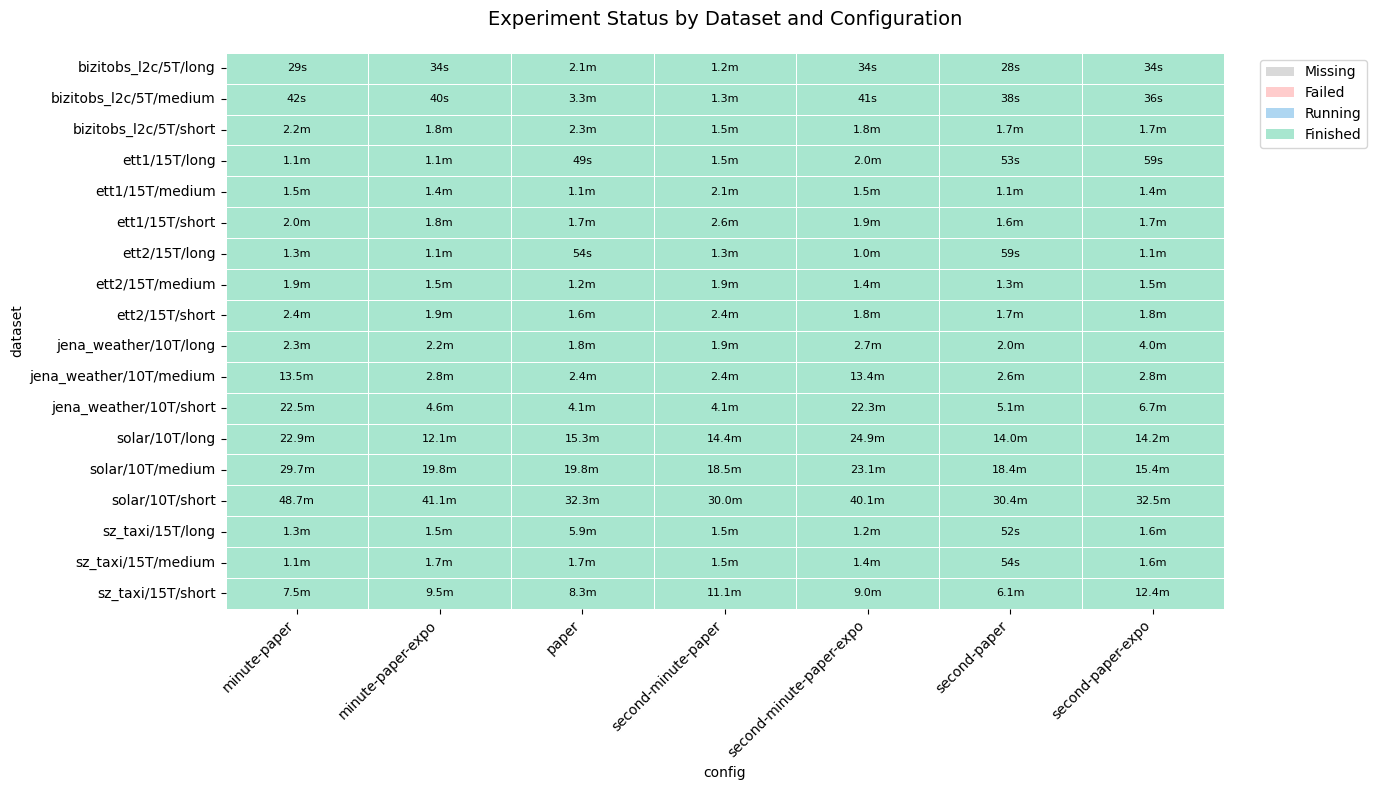

In [5]:
# Create a comprehensive experiment status visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap

# Get all unique datasets and configurations
all_datasets = df['dataset_full_name'].unique()
all_configs = df['config_name'].unique()

# Create a multi-index for all possible combinations
index = pd.MultiIndex.from_product([all_datasets, all_configs], 
                                   names=['dataset', 'config'])

# Create an empty DataFrame with the multi-index
status_df = pd.DataFrame(index=index)

# Add a column to track experiment state
status_df['state'] = 'missing'  # Default state is missing
# Add a column to track runtime
status_df['runtime'] = np.nan  # Default runtime is NaN

# Handle duplicates by keeping the latest result (based on _timestamp if available)
if '_timestamp' in df.columns:
    # Sort by timestamp to get the latest results first
    df_sorted = df.sort_values('_timestamp', ascending=False)
    # Drop duplicates keeping the first occurrence (which is the latest due to sorting)
    df_deduped = df_sorted.drop_duplicates(subset=['dataset_full_name', 'config_name'])
else:
    # If no timestamp, we can use _runtime as a proxy or just keep the first occurrence
    if '_runtime' in df.columns:
        df_sorted = df.sort_values('_runtime', ascending=False)
        df_deduped = df_sorted.drop_duplicates(subset=['dataset_full_name', 'config_name'])
    else:
        # Just keep the first occurrence of each combination
        df_deduped = df.drop_duplicates(subset=['dataset_full_name', 'config_name'])

# Update states and runtimes based on existing experiments (using deduplicated data)
for _, row in df_deduped.iterrows():
    if pd.notna(row['dataset_full_name']) and pd.notna(row['config_name']):
        idx = (row['dataset_full_name'], row['config_name'])
        if idx in status_df.index:
            status_df.loc[idx, 'state'] = row['state']
            # Add runtime information if available
            if '_runtime' in df.columns and pd.notna(row['_runtime']):
                status_df.loc[idx, 'runtime'] = row['_runtime']

# Reshape for better visualization
heatmap_df = status_df.reset_index().pivot_table(
    index='dataset',
    columns='config',
    values='state',
    aggfunc='first'
)

# Create a runtime heatmap for finished experiments
runtime_df = status_df[status_df.state == 'finished'].reset_index().pivot_table(
    index='dataset',
    columns='config',
    values='runtime',
    aggfunc='first'
)

# Create a custom colormap for the states
state_mapping = {'missing': 0, 'failed': 1, 'running': 2, 'finished': 3}
numeric_heatmap = heatmap_df.map(lambda x: state_mapping.get(x, -1))

# Define colors for each state
colors = ['#d9d9d9', '#ffcccc', '#aed6f1', '#a8e6cf']  # gray, light red, light blue, light green
cmap = ListedColormap(colors)

# Plot the heatmap
plt.figure(figsize=(14, 8))
ax = sns.heatmap(numeric_heatmap, cmap=cmap, cbar=False, linewidths=0.5, 
                 linecolor='white', vmin=0, vmax=3)

# Add runtime annotations for finished experiments
for i, dataset in enumerate(heatmap_df.index):
    for j, config in enumerate(heatmap_df.columns):
        runtime = runtime_df.loc[dataset, config] if dataset in runtime_df.index and config in runtime_df.columns else np.nan
        if pd.notna(runtime):
            # Format runtime as minutes if it's large enough
            if runtime >= 60:
                runtime_text = f"{runtime/60:.1f}m"
            else:
                runtime_text = f"{runtime:.0f}s"
            ax.text(j + 0.5, i + 0.5, runtime_text, ha='center', va='center', 
                    color='black', fontsize=8)

# Add a custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors[0], label='Missing'),
    Patch(facecolor=colors[1], label='Failed'),
    Patch(facecolor=colors[2], label='Running'),
    Patch(facecolor=colors[3], label='Finished')
]
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))

plt.title('Experiment Status by Dataset and Configuration', fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# # Print summary statistics
# state_counts = status_df['state'].value_counts()
# total_count = len(status_df)
# print("Experiment Status Summary:")
# for state, count in state_counts.items():
#     print(f"  {state.capitalize()}: {count} ({count/total_count:.1%})")

# # Show missing experiments that should be prioritized
# print("\nMissing Experiments (Top 7):")
# missing_experiments = status_df[status_df['state'] == 'missing'].reset_index().head(7)
# missing_experiments


In [6]:
import numpy as np
from scipy.stats import gmean

# Create pivot table with config_name as index and metrics as columns
pivot_df = df.groupby('config_name').agg({
    'MASE_0.5': lambda x: gmean(np.maximum(x, 1e-10)),
    'wSQL_mean': lambda x: gmean(np.maximum(x, 1e-10))
})

# Sort by MASE_0.5 for better visualization
pivot_df.sort_values('MASE_0.5')

,MASE_0.5,wSQL_mean
config_name,,
second-minute-paper,0.736466,0.166214
minute-paper,0.737690,0.166404
minute-paper-expo,0.740141,0.167259
second-minute-paper-expo,0.741138,0.167561
paper,0.750718,0.170618
second-paper-expo,0.751024,0.170431
second-paper,0.751130,0.170571


In [7]:
import numpy as np
from scipy.stats import gmean

# Create pivot table with config_name and term as indices and metrics as columns
pivot_df = df.groupby(['term', 'config_name']).agg({
    'MASE_0.5': lambda x: gmean(np.maximum(x, 1e-10)),
    'wSQL_mean': lambda x: gmean(np.maximum(x, 1e-10))
})

pivot_df.sort_values(['term', 'MASE_0.5'], ascending=[False, True])

MASE_0.5  wSQL_mean
term   config_name                                  
short  second-minute-paper       0.576255   0.127873
       minute-paper              0.577876   0.127830
       minute-paper-expo         0.578626   0.128245
       second-minute-paper-expo  0.580083   0.128755
       second-paper-expo         0.596450   0.132743
       second-paper              0.596710   0.132917
       paper                     0.596864   0.132816
medium second-minute-paper       0.804519   0.183057
       minute-paper              0.805547   0.183505
       minute-paper-expo         0.808558   0.184544
       second-minute-paper-expo  0.809050   0.184635
       second-paper-expo         0.815511   0.186319
       second-paper              0.815704   0.186453
       paper                     0.817384   0.187347
long   second-minute-paper       0.861605   0.196175
       minute-paper              0.862374   0.196431
       minute-paper-expo         0.866629   0.197709
       paper                     0.867219   0.199609
       second-minute-paper-expo  0.867424   0.197897
       second-paper              0.870661   0.200246
       second-paper-expo         0.870877   0.200158

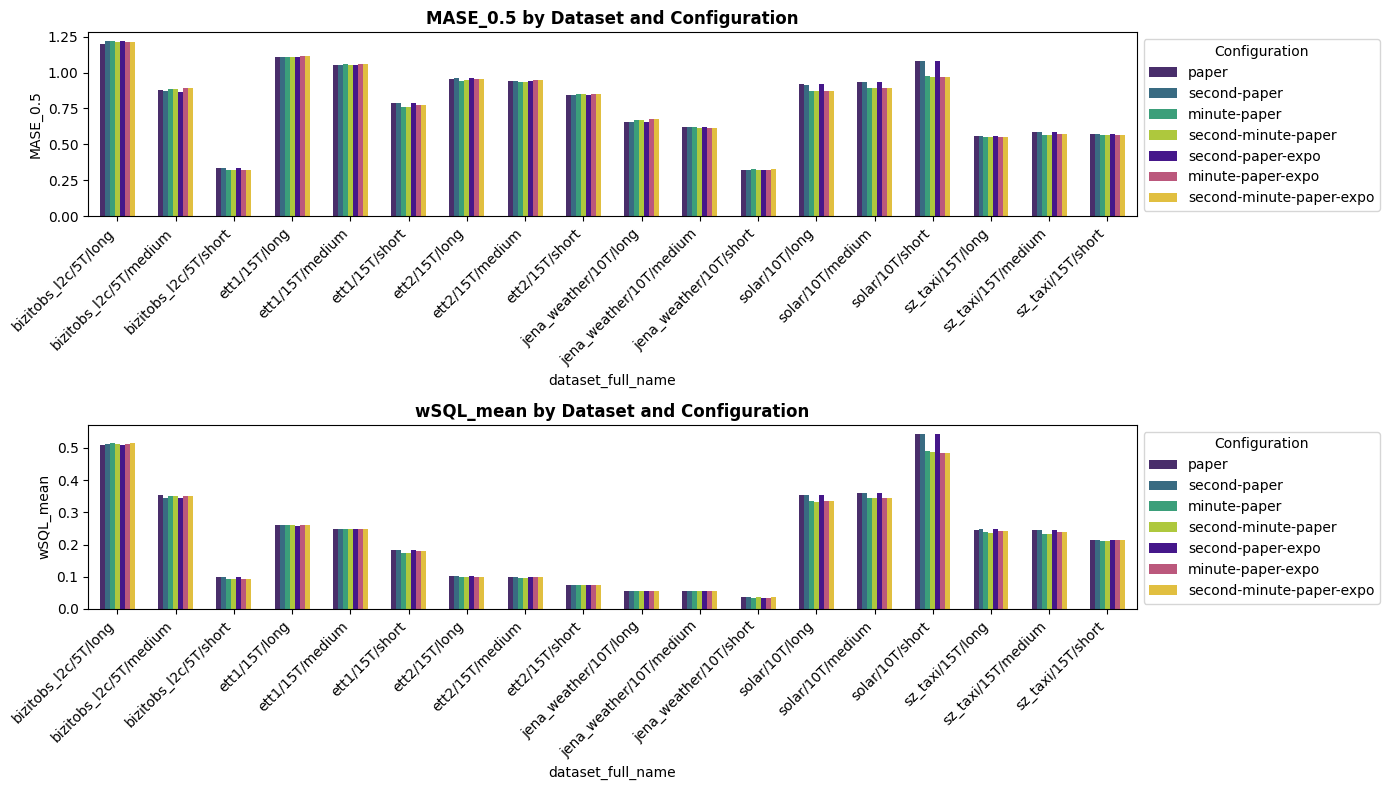

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.colors as mcolors

# Prepare data for plotting
plot_df = df.copy()

# Sort the dataframe by dataset_full_name
plot_df = plot_df.sort_values('dataset_full_name')

# Define a better color scheme - using a more distinct and visually appealing palette
# Using a combination of viridis and plasma for better differentiation
colors = plt.cm.viridis(np.linspace(0.1, 0.9, 4))
colors2 = plt.cm.plasma(np.linspace(0.1, 0.9, 3))
custom_palette = list(colors) + list(colors2)

# Create a categorical type with the desired order
config_order = [
    "paper",
    "second-paper",
    "minute-paper",
    "second-minute-paper",
    "second-paper-expo",
    "minute-paper-expo",
    "second-minute-paper-expo",
]
plot_df['config_name'] = pd.Categorical(plot_df['config_name'], categories=config_order, ordered=True)

# Set figure size
plt.figure(figsize=(14, 8))

# Create grouped bar plot for MASE_0.5 with thinner bars
plt.subplot(2, 1, 1)
sns.barplot(x='dataset_full_name', y='MASE_0.5', hue='config_name', data=plot_df, palette=custom_palette, width=0.6, hue_order=config_order)
plt.title('MASE_0.5 by Dataset and Configuration', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Configuration', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()

# Create grouped bar plot for wSQL_mean with thinner bars
plt.subplot(2, 1, 2)
sns.barplot(x='dataset_full_name', y='wSQL_mean', hue='config_name', data=plot_df, palette=custom_palette, width=0.6, hue_order=config_order)
plt.title('wSQL_mean by Dataset and Configuration', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Configuration', bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.show()
